In [1]:
import pandas as pd

import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
full_bike_data = pd.read_csv('metro-bike-share-trip-data.csv')

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#rename the columns for ease 
full_bike_data.columns = [str.lower(col).replace(" ","_") for col in full_bike_data.columns]

In [4]:
#Which trip route category is most common? 
full_bike_data.groupby('trip_route_category').count()

,trip_id,duration,start_time,end_time,starting_station_id,starting_station_latitude,starting_station_longitude,ending_station_id,ending_station_latitude,ending_station_longitude,bike_id,plan_duration,passholder_type,starting_lat-long,ending_lat-long
trip_route_category,,,,,,,,,,,,,,,
One Way,119642,119642,119642,119642,119623,119597,119597,119546,118594,118594,119640,119026,119642,88980,118594
Round Trip,12785,12785,12785,12785,12785,12782,12782,12785,12782,12782,12777,12635,12785,9642,12782


In [5]:
#number the bike trips for any individual bike. 
#compute the euclidean distance between two stations (which we can use to vet some methodologies)

def euc_dist(r,x1,x2,y1,y2): 
    return np.sqrt((r[x2]-r[x1])**2 + (r[y2]-r[y1])**2)

full_bike_data['bike_trip_num'] = full_bike_data.sort_values(by=['bike_id','trip_id']).groupby('bike_id').cumcount()
full_bike_data['station_dist_euc'] = euc_dist(full_bike_data,'starting_station_latitude','ending_station_latitude','starting_station_longitude','ending_station_longitude')

In [6]:
# appears to be something up with the station 3000 ?? Long/lat do not exist 
full_bike_data[full_bike_data['station_dist_euc'].isnull()].head()

,trip_id,duration,start_time,end_time,starting_station_id,starting_station_latitude,starting_station_longitude,ending_station_id,ending_station_latitude,ending_station_longitude,bike_id,plan_duration,trip_route_category,passholder_type,starting_lat-long,ending_lat-long,bike_trip_num,station_dist_euc
55444,8410788,31680,2016-10-01T00:58:00,2016-10-01T09:46:00,3082.0,34.046520,-118.237411,3000.0,NaN,NaN,5838.0,30.0,One Way,Monthly Pass,"{'longitude': '-118.237411', 'latitude': '34.0...",NaN,77,NaN
55463,8424833,39000,2016-10-01T02:03:00,2016-10-01T12:53:00,3037.0,34.034801,-118.231277,3000.0,NaN,NaN,6197.0,0.0,One Way,Walk-up,"{'longitude': '-118.231277', 'latitude': '34.0...",NaN,81,NaN
55517,8415350,2760,2016-10-01T10:07:00,2016-10-01T10:53:00,3040.0,34.053570,-118.266357,3000.0,NaN,NaN,5830.0,30.0,One Way,Monthly Pass,"{'longitude': '-118.266357', 'latitude': '34.0...",NaN,39,NaN
55547,8419995,1680,2016-10-01T10:58:00,2016-10-01T11:26:00,3049.0,34.056969,-118.253593,3000.0,NaN,NaN,5808.0,30.0,One Way,Monthly Pass,"{'longitude': '-118.253593', 'latitude': '34.0...",NaN,59,NaN
55639,8444038,8640,2016-10-01T13:39:00,2016-10-01T16:03:00,3052.0,34.051102,-118.264557,3000.0,NaN,NaN,5931.0,30.0,One Way,Monthly Pass,"{'longitude': '-118.264557', 'latitude': '34.0...",NaN,70,NaN


In [8]:
# aggregate unique "trips" - one row per starting station id and ending station id. 
# we can use this to determine the longest trips 

unique_trip_agg = full_bike_data.groupby(['starting_station_id','ending_station_id']).agg({
    'trip_id': np.size,
    'station_dist_euc': np.max, 
    'duration': [np.mean, np.median, np.std]
}).reset_index()


In [9]:
#fix columns in agg'd df 
unique_trip_agg.columns = ['_'.join(col) for col in unique_trip_agg.columns.values]
 

In [10]:
unique_trip_agg.head()

,starting_station_id_,ending_station_id_,trip_id_size,station_dist_euc_amax,duration_mean,duration_median,duration_std
0,3000.0,3000.0,5,NaN,21048.0,60,37410.141940
1,3000.0,3006.0,1,NaN,1080.0,1080,NaN
2,3000.0,3014.0,2,NaN,870.0,870,212.132034
3,3000.0,3030.0,1,NaN,960.0,960,NaN
4,3000.0,3035.0,1,NaN,2160.0,2160,NaN


In [11]:
#unique_trip_agg.sort_values(by='duration_mean',ascending=False)

# if our theory is correct, duration mean and euclidean distance should correlate 
import statsmodels.api as sm

agg_check = unique_trip_agg.dropna()
linear_check = sm.OLS(agg_check['duration_mean'],agg_check['station_dist_euc_amax'])
lin_result = linear_check.fit()
lin_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          duration_mean   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     60.92
Date:                Wed, 24 Oct 2018   Prob (F-statistic):           7.92e-15
Time:                        18:35:53   Log-Likelihood:                -30964.
No. Observations:                3319   AIC:                         6.193e+04
Df Residuals:                    3318   BIC:                         6.194e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
station_dist_euc_amax    41.9364      5.373      7.805      0.000      31.401      52.471
==============================================================================
Omnibus:                     5062.819   Durbin-Watson:                   1.308
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2612044.691
Skew:                           9.381   Prob(JB):                         0.00
Kurtosis:                     139.147   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# aggregate by bike to have an easier method of looking at what bikes have longest duration/most trips 
by_bike = full_bike_data.groupby('bike_id').agg({
    'duration': np.sum, 
    'trip_id': np.size, 
    'starting_station_id': lambda x: x.nunique(),
    'ending_station_id': lambda x: x.nunique()
}).sort_values(by='duration',ascending=False).rename(columns={
    'starting_station_id': 'nunique_starting',
    'ending_station_id': 'nunique_ending'
}).reset_index()

by_bike.sort_values(by='nunique_starting',ascending=False).head(5)

,bike_id,duration,trip_id,nunique_starting,nunique_ending
98,6603.0,385080,222,58.0,56.0
189,6403.0,324180,243,58.0,58.0
254,6236.0,300300,178,57.0,56.0
180,5832.0,326700,224,57.0,56.0
480,6626.0,230700,193,57.0,53.0


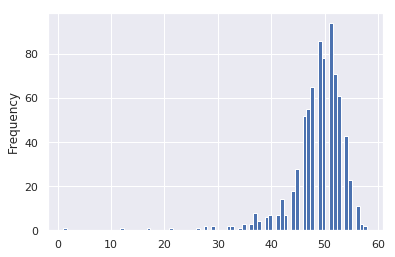

In [13]:
# look at histograms of key metrics 
by_bike['nunique_starting'].plot(kind='hist',bins=80)
plt.show()

In [14]:
stations = pd.concat([full_bike_data['starting_station_id'],full_bike_data['ending_station_id']])
station_counts = stations.value_counts()
station_counts.index.name = 'station'
stations_df = pd.DataFrame(data=station_counts,columns=['occurances'],index=station_counts.index).reset_index()


In [15]:
station_lookup = full_bike_data.dropna().groupby('starting_station_id').head(1)[['starting_station_id','starting_lat-long']]
stations_df = stations_df.merge(station_lookup,how='left',left_on='station',right_on='starting_station_id')
stations_df = stations_df[['station','occurances','starting_lat-long']]

In [16]:
stations_df.rename({'starting_lat-long':'test'}).head()

,station,occurances,starting_lat-long
0,3005.0,11145,"{'longitude': '-118.25905', 'latitude': '34.04..."
1,3069.0,10210,"{'longitude': '-118.24825', 'latitude': '34.05..."
2,3031.0,10146,"{'longitude': '-118.25244', 'latitude': '34.04..."
3,3014.0,9956,"{'longitude': '-118.23721', 'latitude': '34.05..."
4,3042.0,9308,"{'longitude': '-118.23881', 'latitude': '34.04..."


In [21]:
bike_snap = full_bike_data[['bike_id','duration','trip_id']]

In [22]:
bike_snap.count()

bike_id     132417
duration    132427
trip_id     132427
dtype: int64

In [18]:
# #bike_snap.groupby('Bike ID').apply(lambda x: x['Duration'].sum())
# rolling_sum = bike_snap.groupby('Bike ID').rolling(3)['Duration'].sum() #.reset_index()

# #bike_snap.assign(dur_window = rolling_sum)
# rolling_sum.set
# #.index.droplevel(0)